In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy.fft
import matplotlib.pylab as plt

from pyinverse.grid import RegularAxis, FFTRegularAxis, RFFTRegularAxis, RegularGrid
from pyinverse.util import besinc

## 1-D

From e.g., Blahut we have $\text{rect}(t) \leftrightarrow \text{sinc}(f)$. These functions are defined as
\begin{equation}
\text{rect}(t) =
\begin{cases}
1 & |t| \leq \frac12 \\
0 & \text{otherwise}
\end{cases}
\end{equation}
and
\begin{equation}
\text{sinc}(x) = \frac{\sin\pi x}{\pi x}
\end{equation}
where $\text{sinc}(0) = 1$.

From, e.g., Oppenheim and Schaffer, we have that the DFT of the discrete rect window function of length $L$ is
\begin{equation}
W_r(e^{j\omega}) = \sum_{n=0}^{L-1} e^{-j\omega n} = e^{-j\omega(L-1)/2} \frac{\sin(\omega L/2)}{\sin(\omega /2)}
\end{equation}
Note that $W_r(0) = L$.

The discrete rect window function is defined as
\begin{equation}
w_r(n) = 
\begin{cases}
1 & 0 \leq n < L \\
0 & \text{otherwise}
\end{cases}
\end{equation}

In [3]:
Ts = 0.01
N = 501 # chosen to force zero padding (as determined by scipy.fft.next_fast_len)
d = 1/(Ts*N)
t_axis = FFTRegularAxis(N, d=d) 

In [4]:
def rect(t):
    y = np.zeros_like(t)
    y[np.abs(t) <= 0.5] = 1
    return y

In [5]:
y = rect(t_axis)

In [6]:
L = np.count_nonzero(y)
shift = np.argwhere(y > 0)[0][0]

In [7]:
def w_r(n, L):
    y = np.zeros_like(n)
    y[(0 <= n) & (n < L)] = 1
    return y

In [8]:
def W_r(omega, L):
    y = np.empty_like(omega, dtype=np.complex)
    y[omega == 0] = L
    I = omega != 0
    y[I] = np.exp(-1j*omega[I]*(L-1)/2) * np.sin(omega[I]*L/2) / np.sin(omega[I]/2)
    return y

<IPython.core.display.Javascript object>


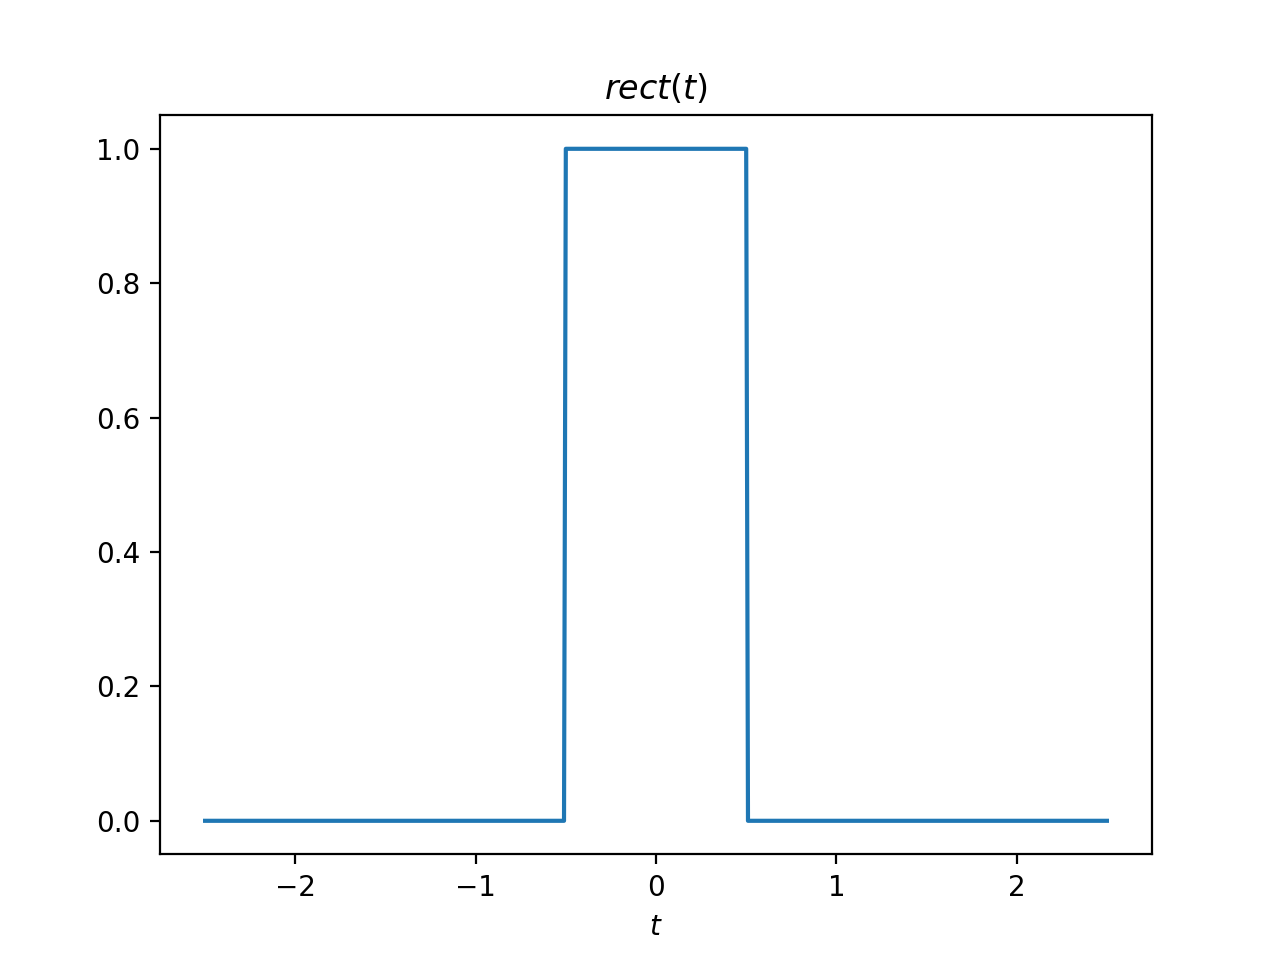

In [9]:
fig, ax = plt.subplots()
ax.plot(t_axis, y)
ax.set_xlabel(r'$t$')
ax.set_title(r'$rect(t)$');

In [10]:
f_axis, Y_ft = t_axis.ft(y)

In [11]:
Fs = 1/Ts
Fn = Fs/2
f = np.linspace(-Fn, Fn, N*8)

In [12]:
Yc_theory = np.sinc(f)

In [13]:
f_axis

FFTRegularAxis(x0=-50.0, T=0.1984126984126984, N=504)

<IPython.core.display.Javascript object>


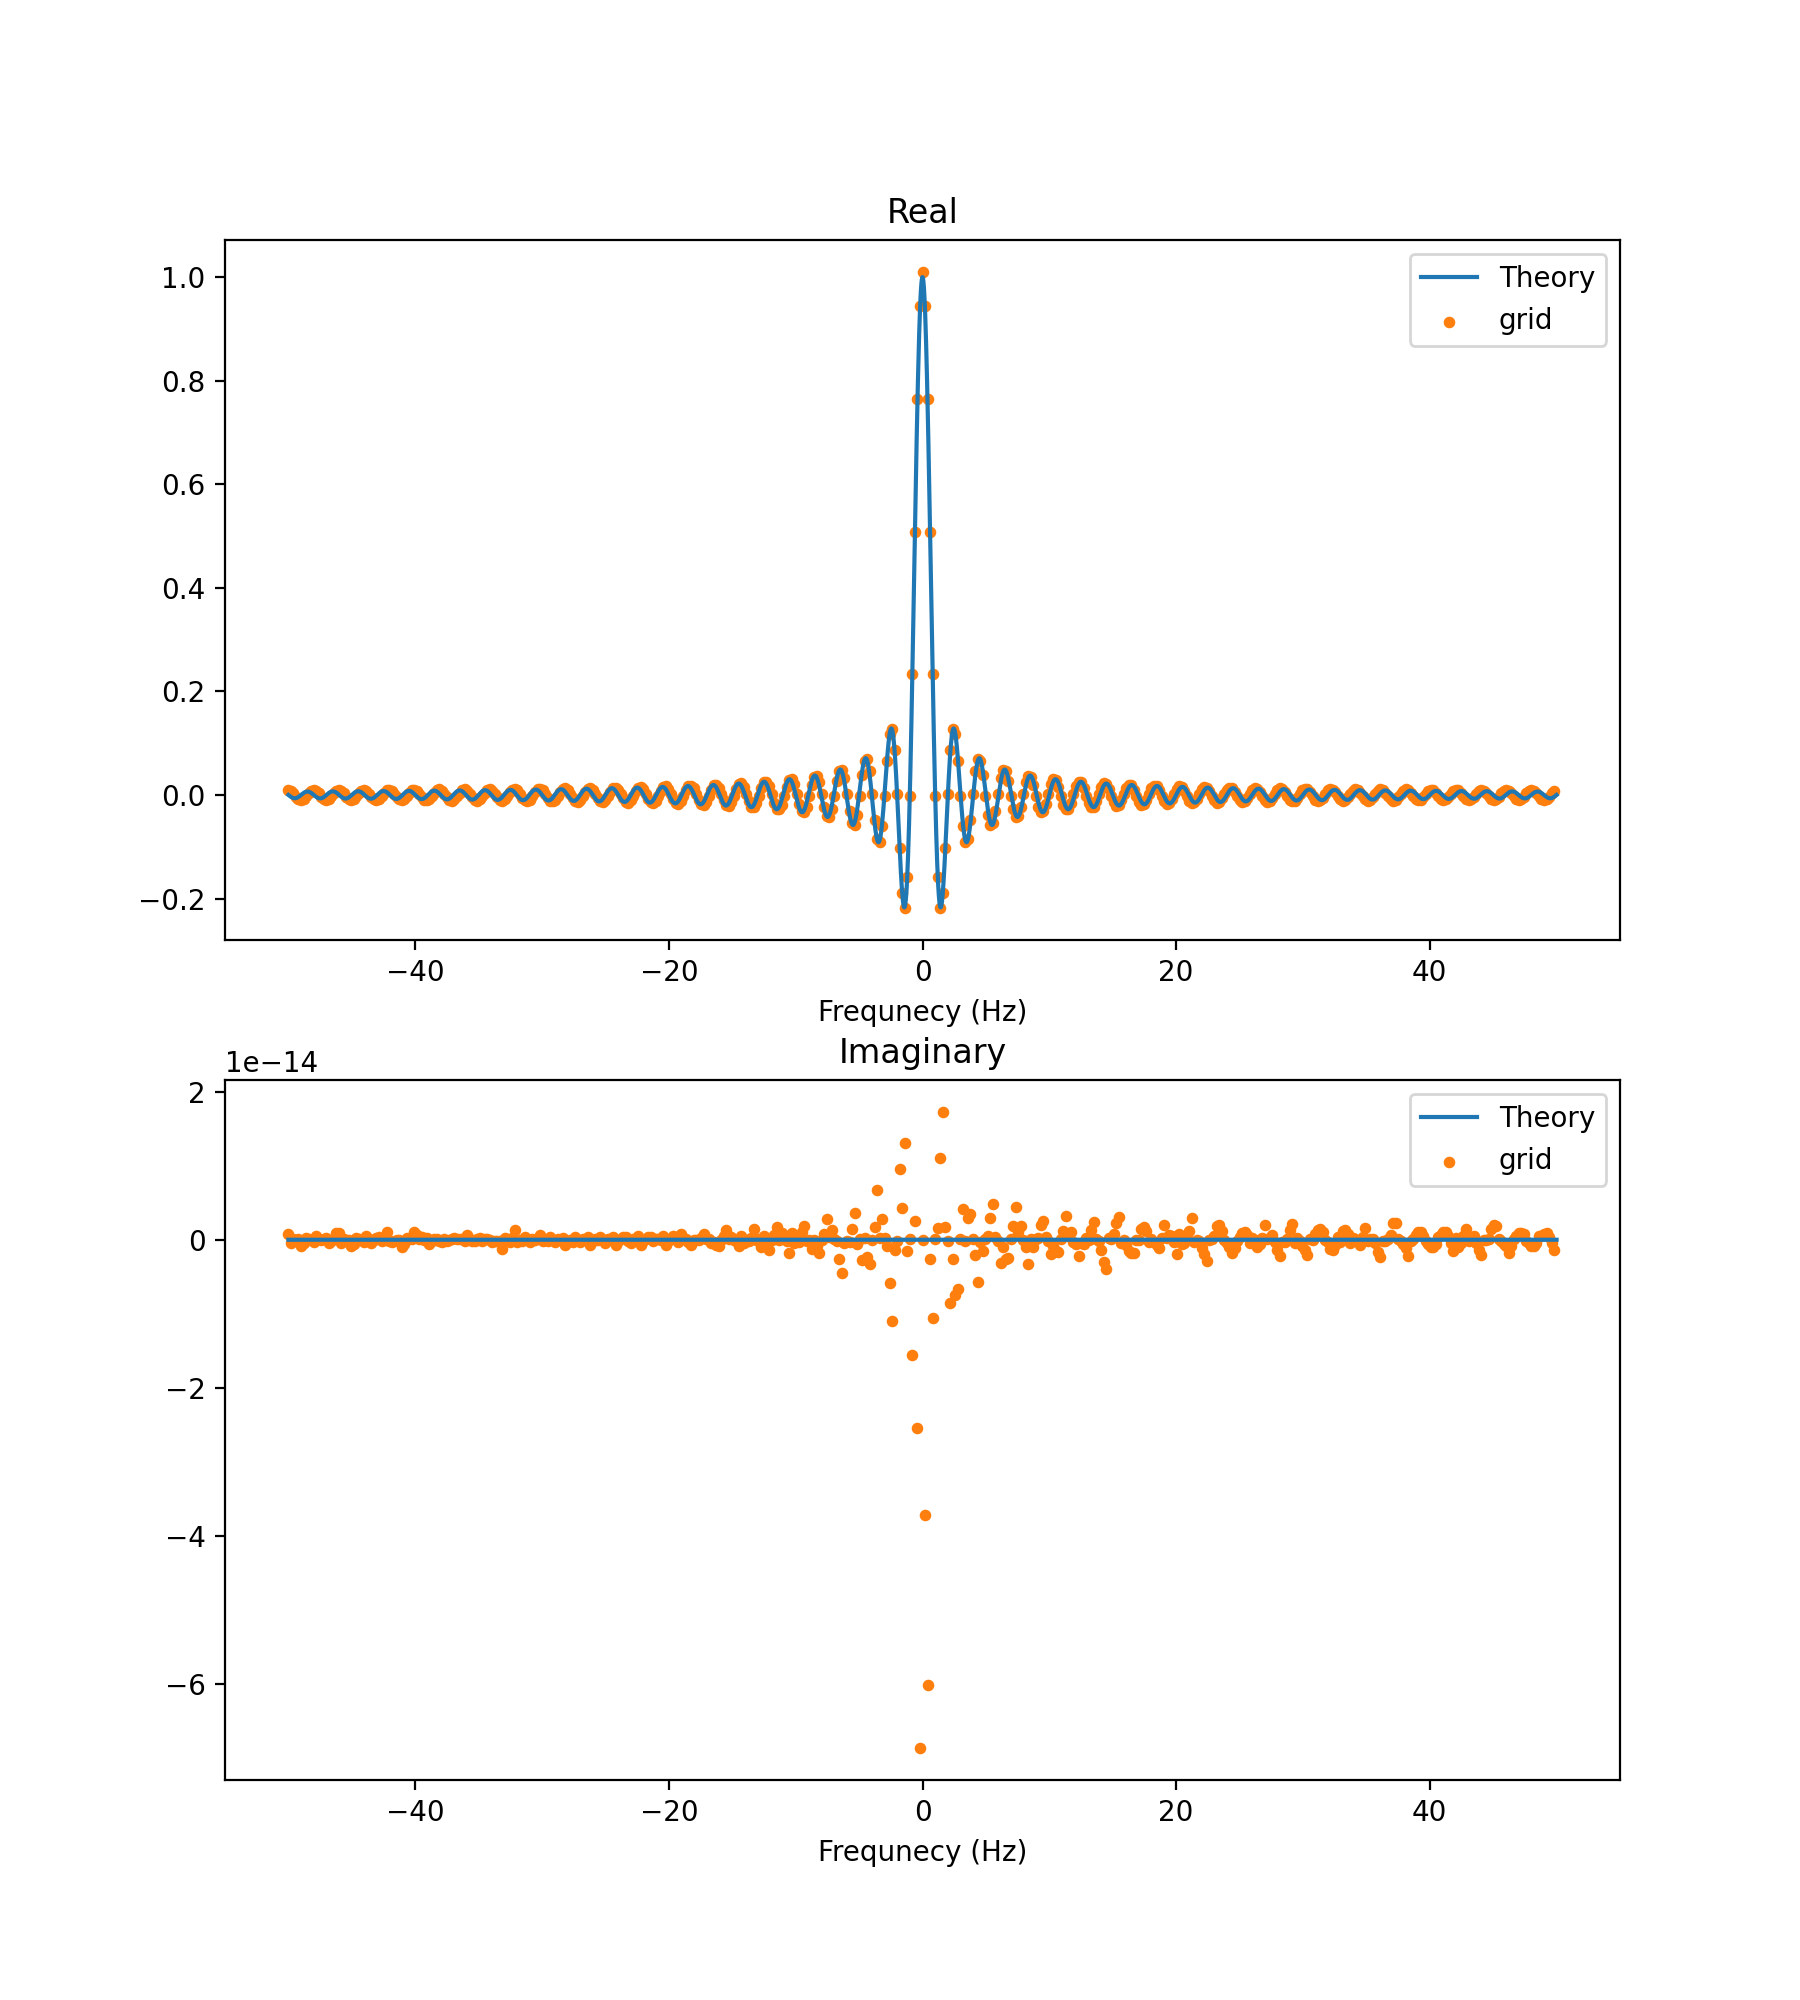

In [14]:
fig, ax = plt.subplots(nrows=2, figsize=(9, 10))
ax[0].plot(f, np.real(Yc_theory), label='Theory')
ax[0].scatter(f_axis.centers, np.real(Y_ft), c='C1', s=10, label='grid')
ax[0].legend()
ax[0].set_xlabel('Frequnecy (Hz)')
ax[0].set_title('Real')
ax[1].plot(f, np.imag(Yc_theory), label='Theory')
ax[1].scatter(f_axis.centers, np.imag(Y_ft), c='C1', s=10, label='grid')
ax[1].legend()
ax[1].set_xlabel('Frequnecy (Hz)')
ax[1].set_title('Imaginary');

In [15]:
t_axis_ift, y_ift = f_axis.ift(Y_ft)

In [16]:
t_axis, t_axis_ift

(FFTRegularAxis(x0=-2.5, T=0.01, N=501),
 FFTRegularAxis(x0=-2.5, T=0.01, N=501))

In [17]:
np.max(np.abs(np.imag(y_ift)))
y_ift = np.real(y_ift)

<IPython.core.display.Javascript object>


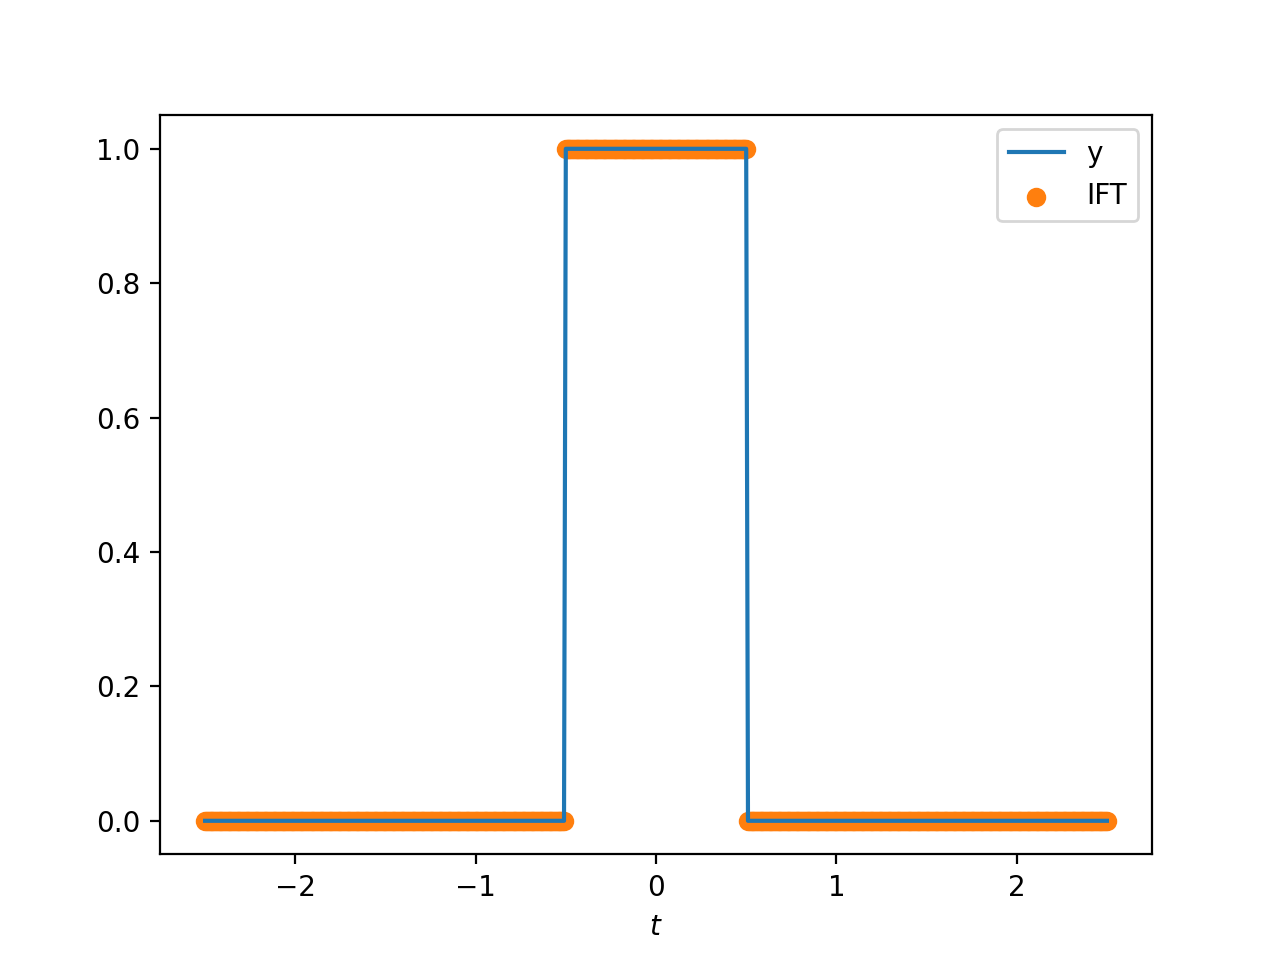

In [18]:
fig, ax = plt.subplots()
ax.plot(t_axis, y, label='y')
ax.scatter(t_axis.centers, y_ift, c='C1', label='IFT')
ax.set_xlabel(r'$t$')
ax.legend();

In [19]:
f_axis_real, Y_ft_real = t_axis.ft(y, real=True)

<IPython.core.display.Javascript object>


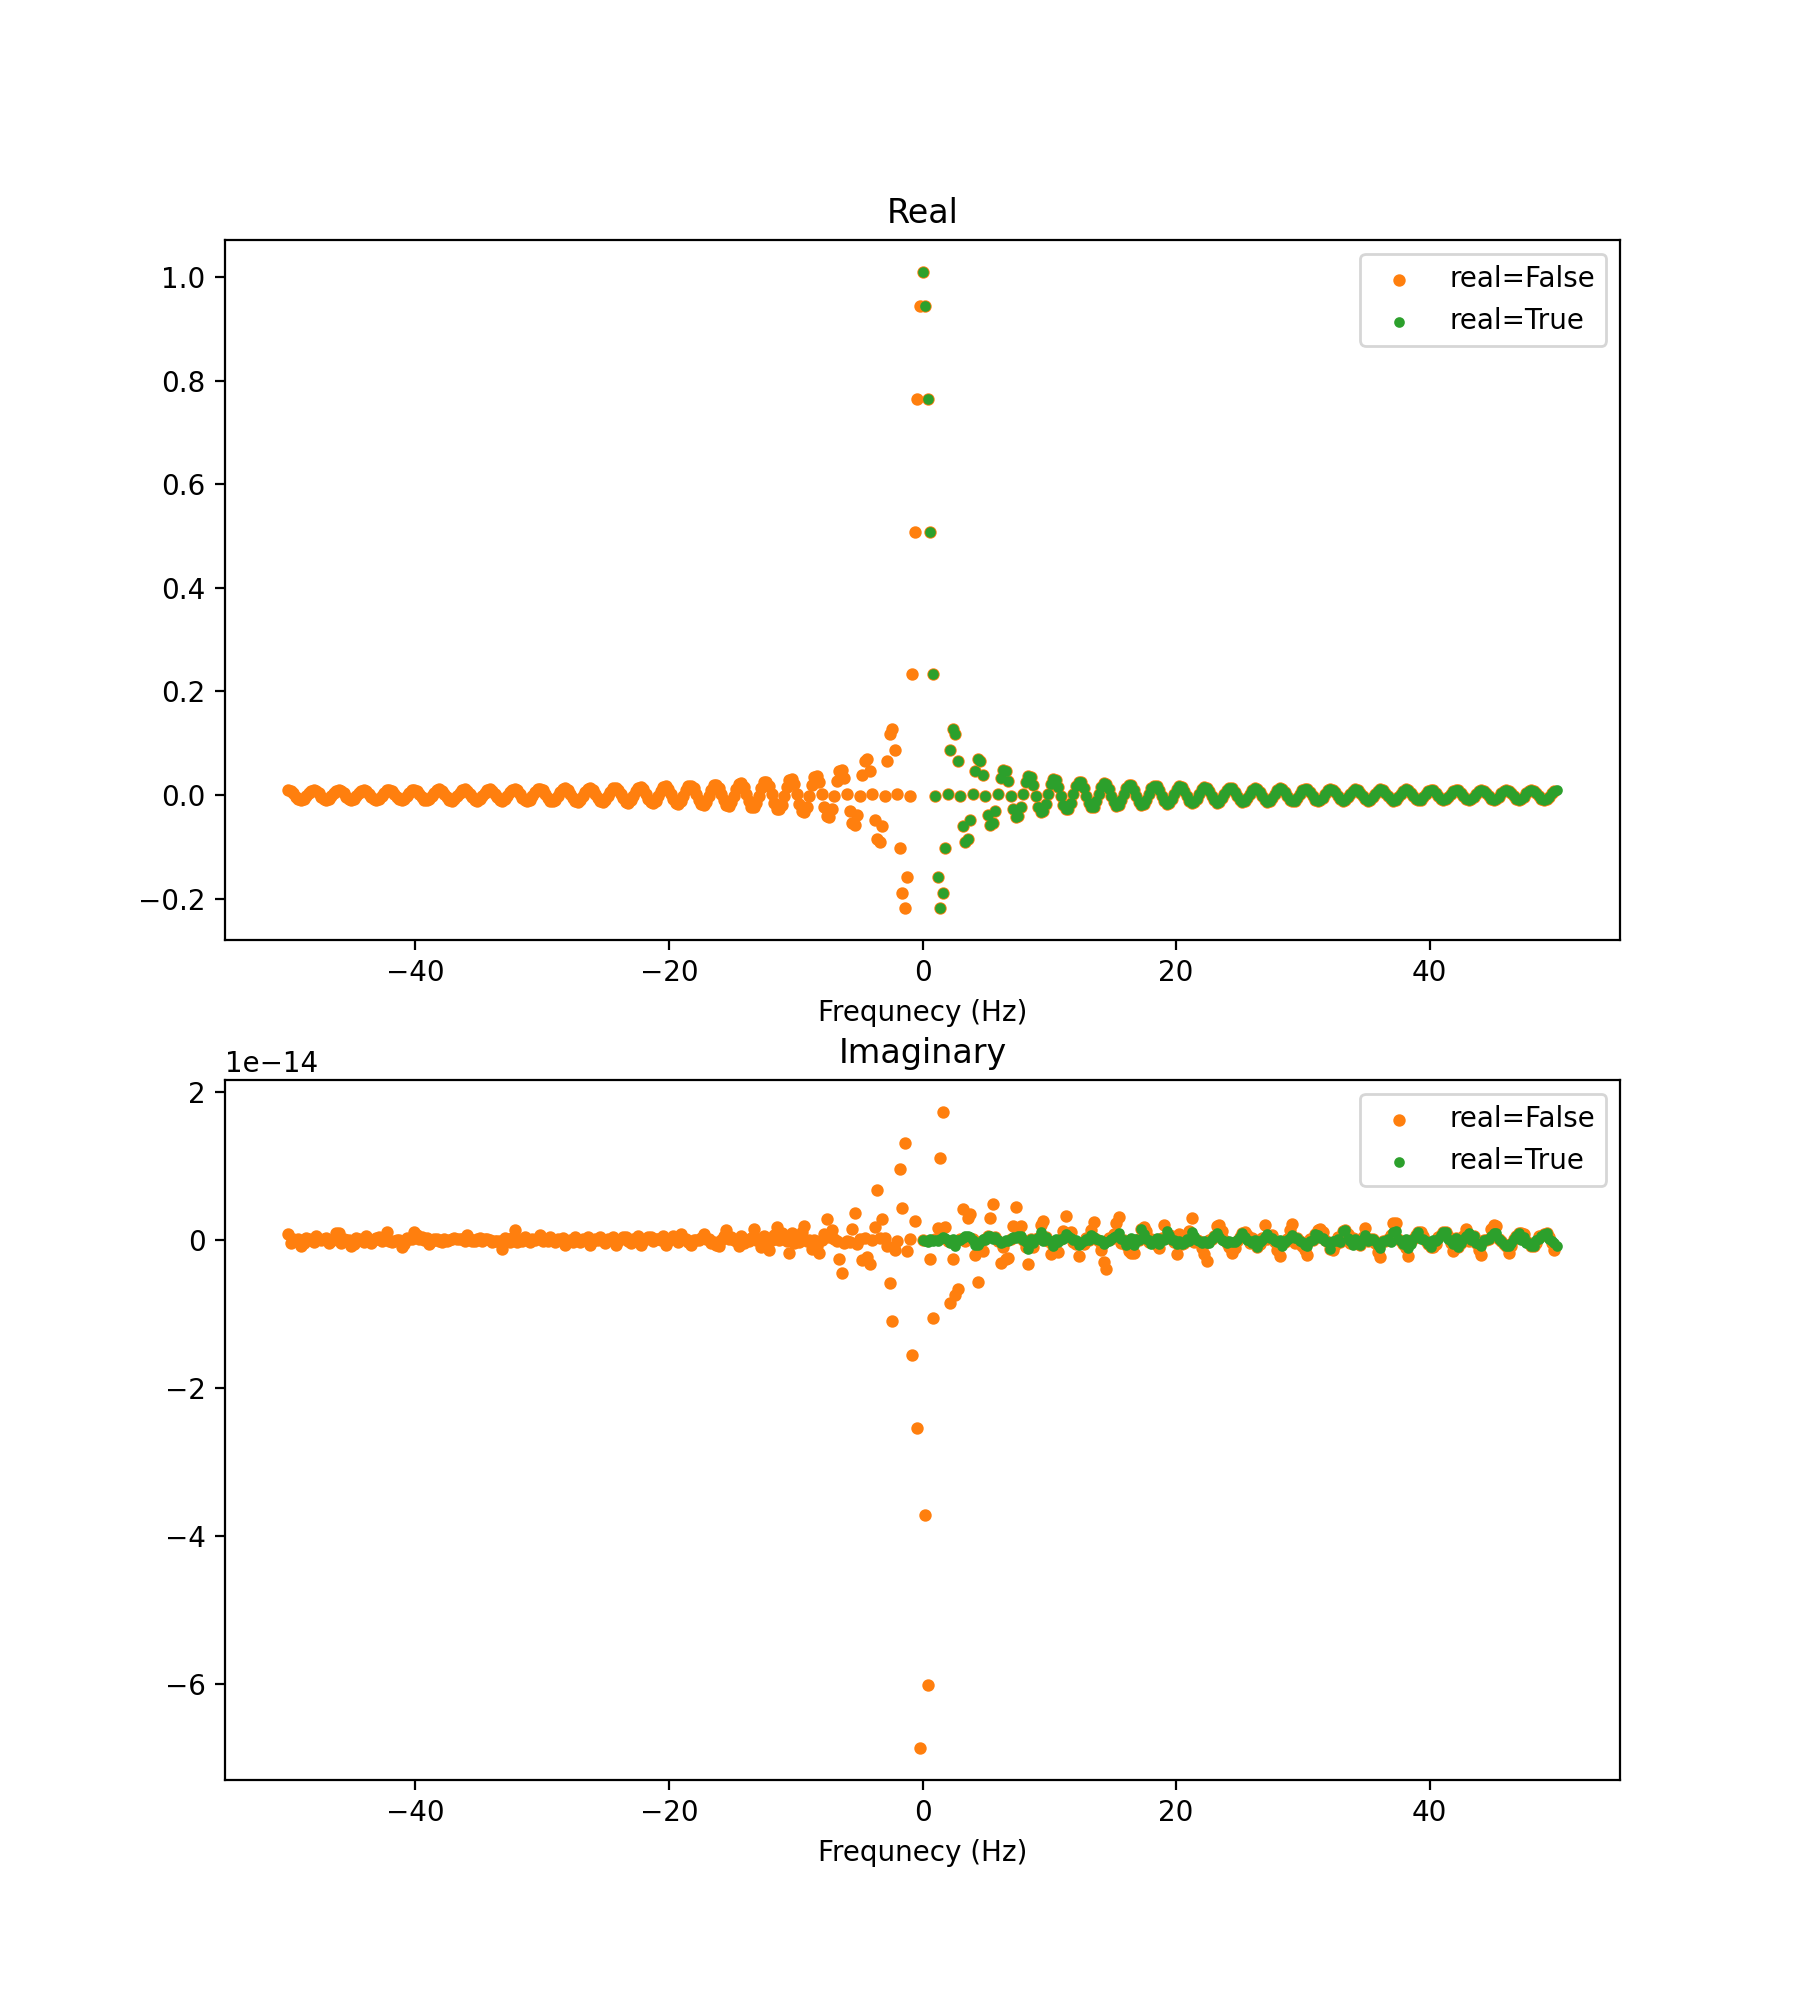

In [20]:
fig, ax = plt.subplots(nrows=2, figsize=(9, 10))
ax[0].scatter(f_axis.centers, np.real(Y_ft), s=12, c='C1', label='real=False')
ax[0].scatter(f_axis_real.centers, np.real(Y_ft_real), s=8, c='C2', label='real=True')
ax[0].legend()
ax[0].set_xlabel('Frequnecy (Hz)')
ax[0].set_title('Real')
ax[1].scatter(f_axis.centers, np.imag(Y_ft), s=12, c='C1', label='real=False')
ax[1].scatter(f_axis_real.centers, np.imag(Y_ft_real), s=8, c='C2', label='real=True')
ax[1].legend()
ax[1].set_xlabel('Frequnecy (Hz)')
ax[1].set_title('Imaginary');

In [21]:
t_axis_ift_real, y_ift_real = f_axis_real.ift(Y_ft_real)

In [22]:
y_ift_real.shape

(501,)

In [23]:
t_axis_ift_real

FFTRegularAxis(x0=-2.5, T=0.01, N=501)

In [24]:
t_axis_ift

FFTRegularAxis(x0=-2.5, T=0.01, N=501)

<IPython.core.display.Javascript object>


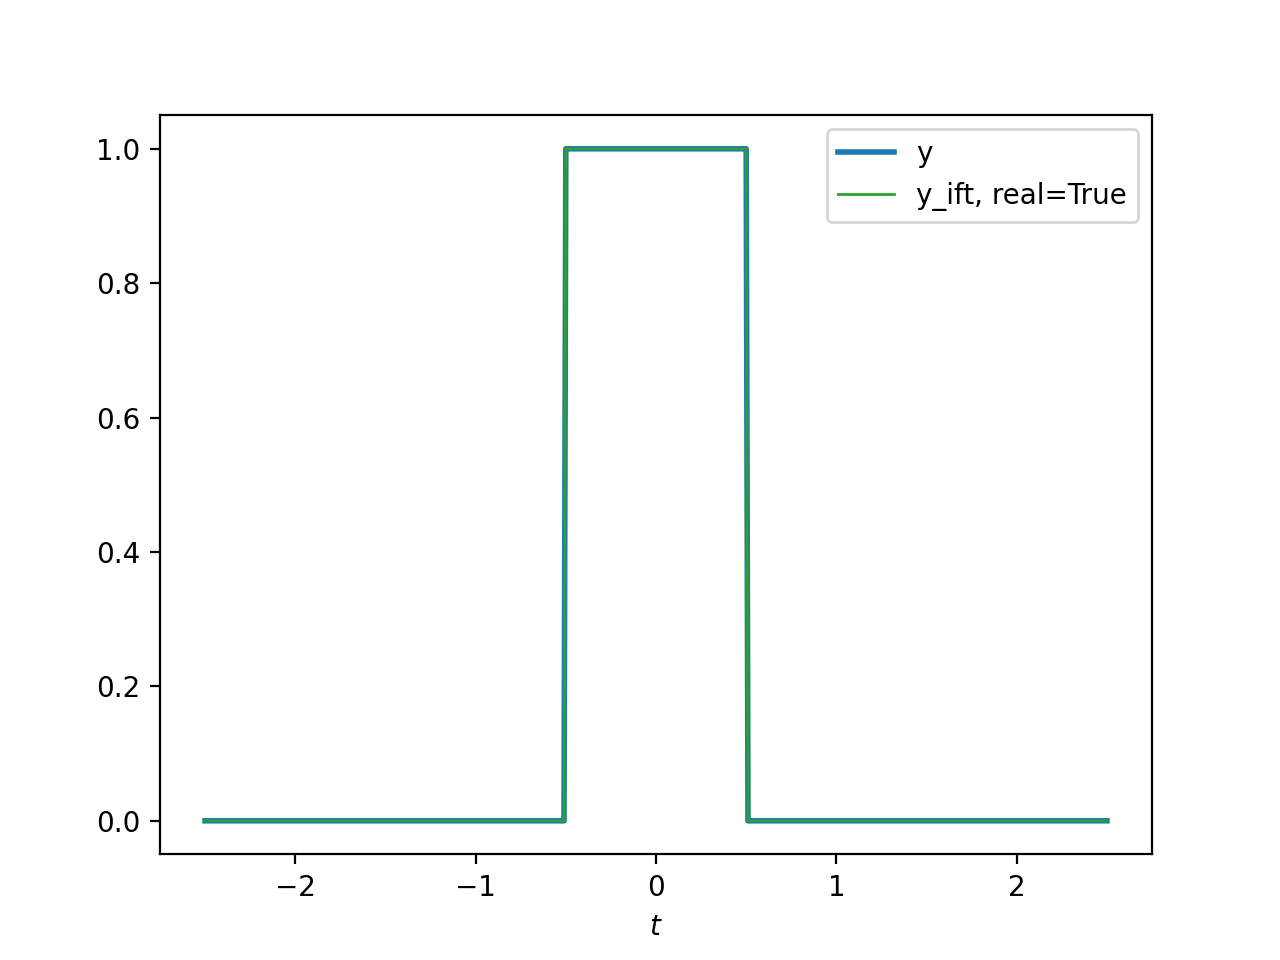

In [25]:
fig, ax = plt.subplots()
ax.plot(t_axis.centers, y, c='C0', lw=2, label='y')
ax.plot(t_axis_ift_real.centers, y_ift_real, c='C2', lw=1, label='y_ift, real=True')
ax.legend()
ax.set_xlabel(r'$t$');

## 2-D

From Blahut we have $\text{circ}(x, y) \leftrightarrow \text{jinc}(f_x, f_y)$ where

\begin{equation}
\text{circ}(x, y) = \text{rect}\bigl(\sqrt{x^2 + y^2}\bigr)
\begin{cases}
1 & \sqrt{x^2 + y^2} \leq \frac12 \\
0 & \text{otherwise}
\end{cases}
\end{equation}

and $\text{jinc}(f_x, f_y) = \text{jinc}(\sqrt{f_x^2 + f_y^2})$ where

\begin{equation}
\text{jinc}(t) = \frac{J_1(\pi t)}{2t}
\end{equation}

and $J_1(x)$ is a the first-order Bessel function of the first kind and $\text{jinc}(0) = \frac{\pi}{4}$.

In [26]:
Ts_x = 0.01
#N_x = 501 # chosen to force zero padding (as determined by scipy.fft.next_fast_len) to 504 (even)
N_x = 513 # chosen to force zero padding (as determined by scipy.fft.next_fast_len) to 525 (odd)
d_x = 1/(Ts_x*N_x)
x_axis = FFTRegularAxis(N_x, d=d_x) 

In [27]:
Ts_y = 0.01
#N_y = 501 # chosen to force zero padding (as determined by scipy.fft.next_fast_len)
#N_y = 513
Ts_y = 0.05
N_y = 100
d_y = 1/(Ts_y*N_y)
y_axis = FFTRegularAxis(N_y, d=d_y) 

In [28]:
grid = RegularGrid(x_axis, y_axis)

In [29]:
circ = lambda x, y: rect(np.sqrt(x**2 + y**2))   # too slow
circ_vec = np.vectorize(circ, otypes=[np.float])

In [30]:
D = np.sqrt(grid.centers[0]**2 + grid.centers[1]**2)
y = np.zeros_like(D)
y[D <= 1/2] = 1

<IPython.core.display.Javascript object>


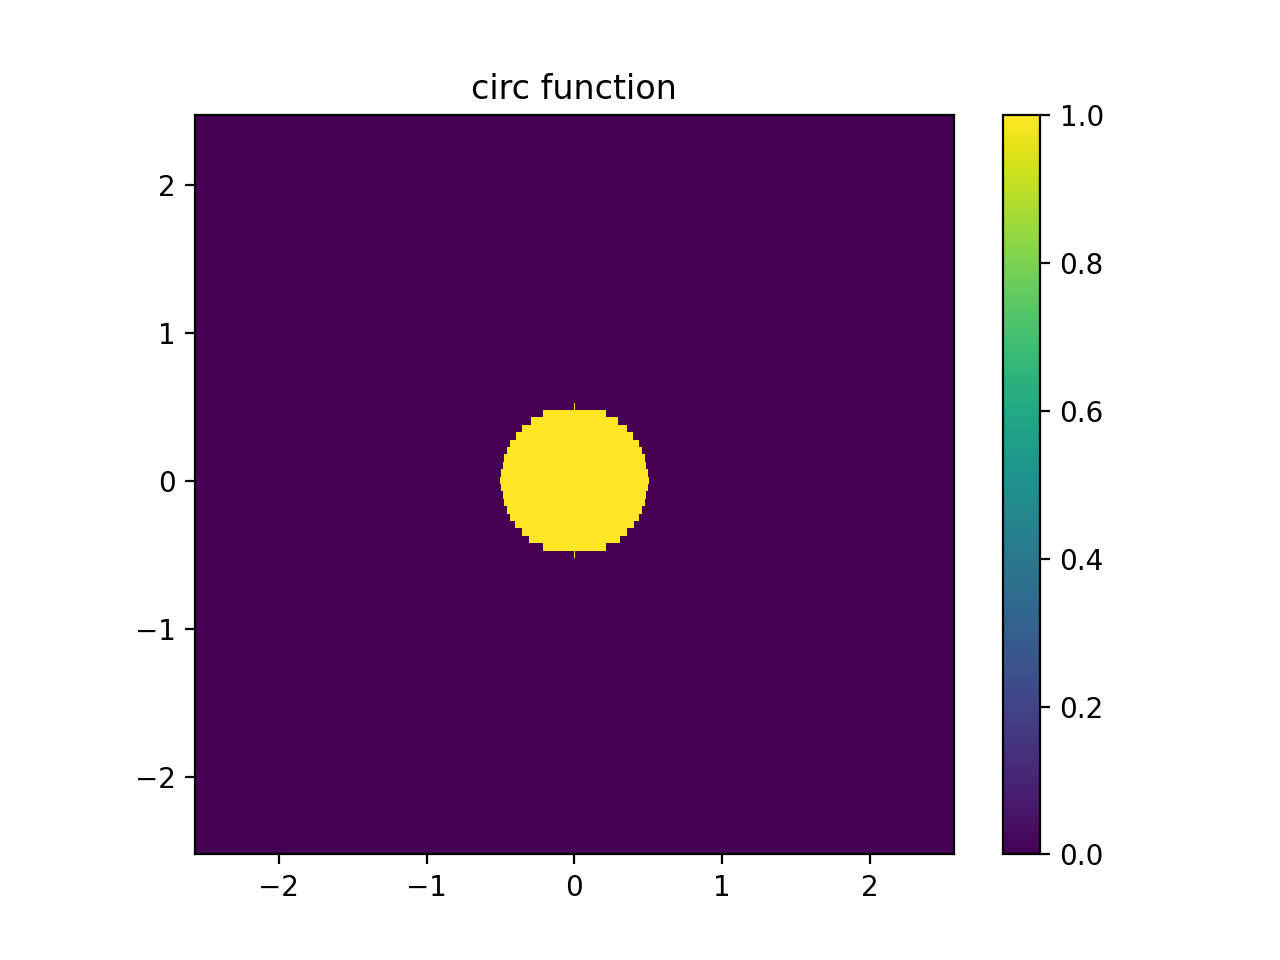

In [31]:
fig, ax = plt.subplots()
im = grid.imshow(ax, y)
fig.colorbar(im)
ax.set_title('circ function');

In [32]:
f_grid, Y = grid.dft(y)

<IPython.core.display.Javascript object>


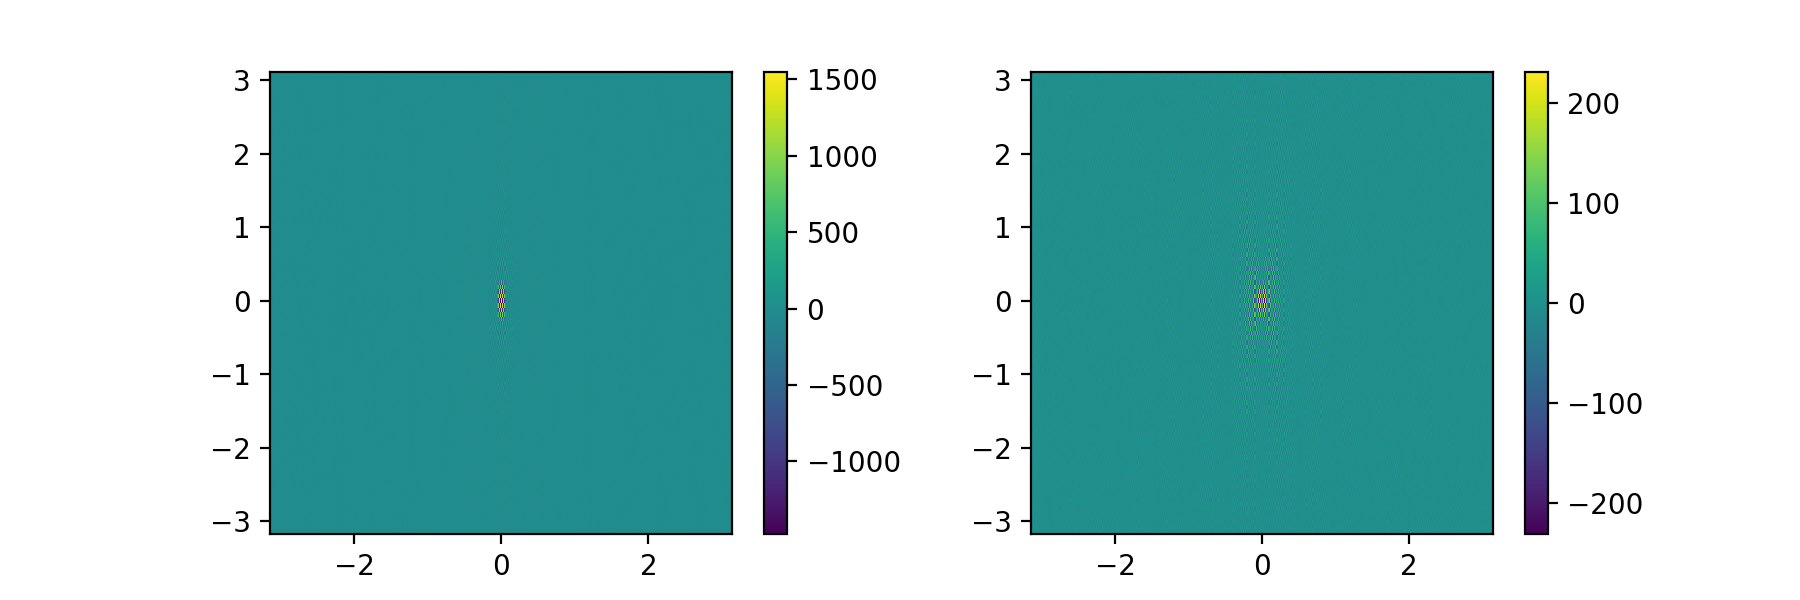

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
im = f_grid.imshow(ax[0], np.real(Y))
fig.colorbar(im, ax=ax[0])
im = f_grid.imshow(ax[1], np.imag(Y))
fig.colorbar(im, ax=ax[1])

<IPython.core.display.Javascript object>


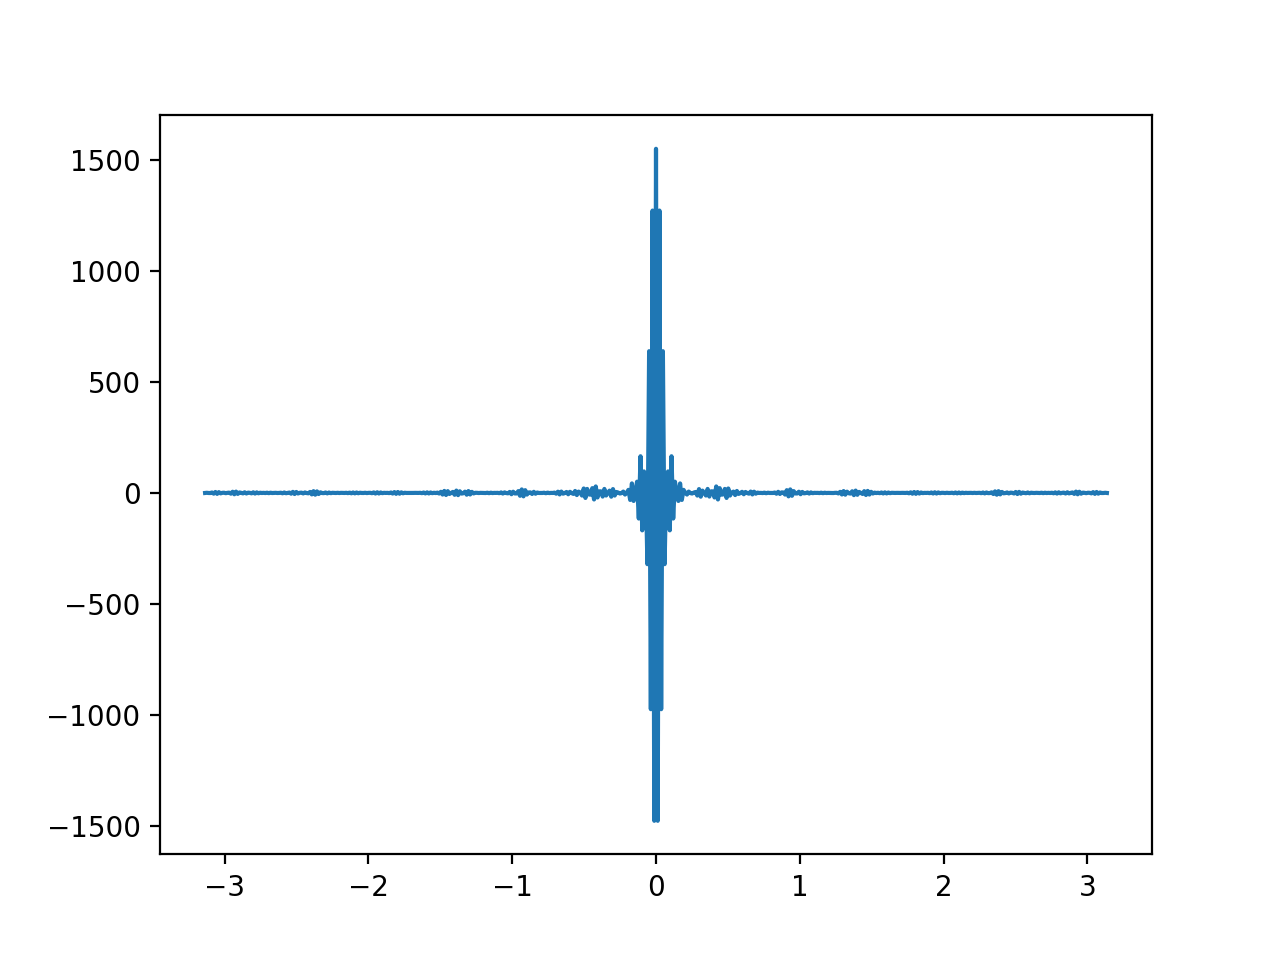

In [34]:
fig, ax = plt.subplots()
ax.plot(f_grid.axis_x.centers,
        np.real(scipy.fft.fftshift(Y, axes=0))[0, :])

In [35]:
f_grid_ft, Y_ft = grid.ft(y) 

<IPython.core.display.Javascript object>


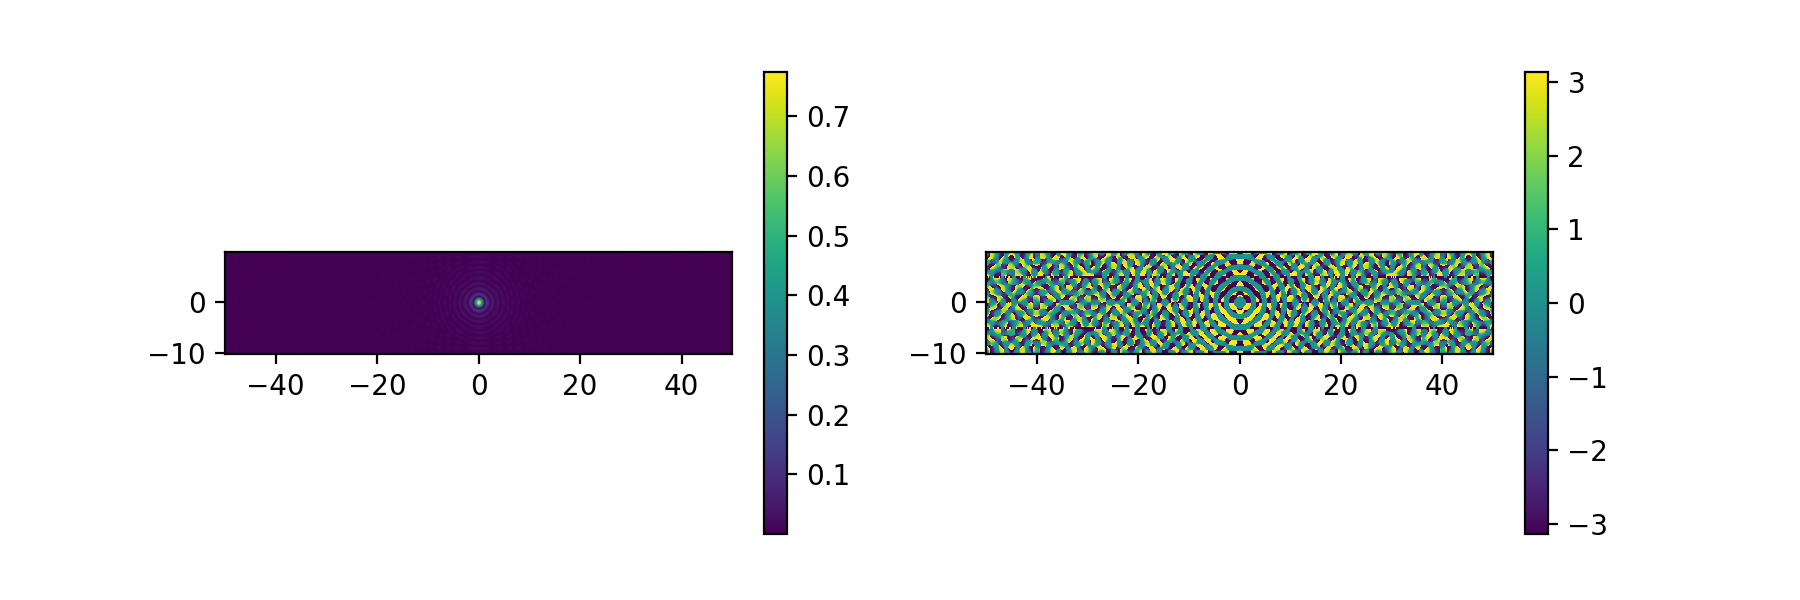

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
im = f_grid_ft.imshow(ax[0], np.abs(Y_ft))
fig.colorbar(im, ax=ax[0])
im = f_grid_ft.imshow(ax[1], np.angle(Y_ft))
vmin, vmax = im.get_clim()
fig.colorbar(im, ax=ax[1])

In [37]:
Yc_theory = besinc(np.sqrt(np.sum(np.square(f_grid_ft.centers), axis=0)))

<IPython.core.display.Javascript object>


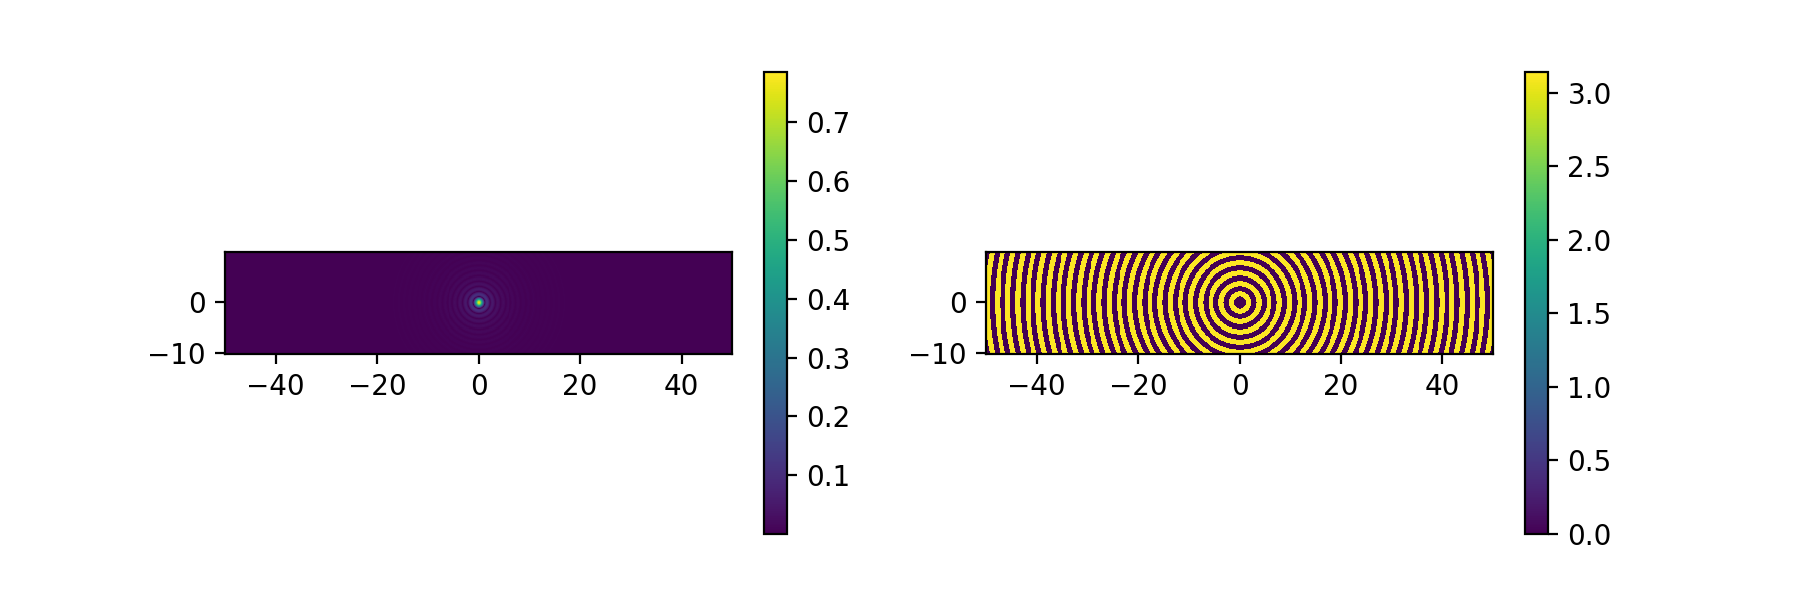

In [38]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
im = f_grid_ft.imshow(ax[0], np.abs(Yc_theory))
fig.colorbar(im, ax=ax[0])
im = f_grid_ft.imshow(ax[1], np.angle(Yc_theory))
fig.colorbar(im, ax=ax[1])

<IPython.core.display.Javascript object>


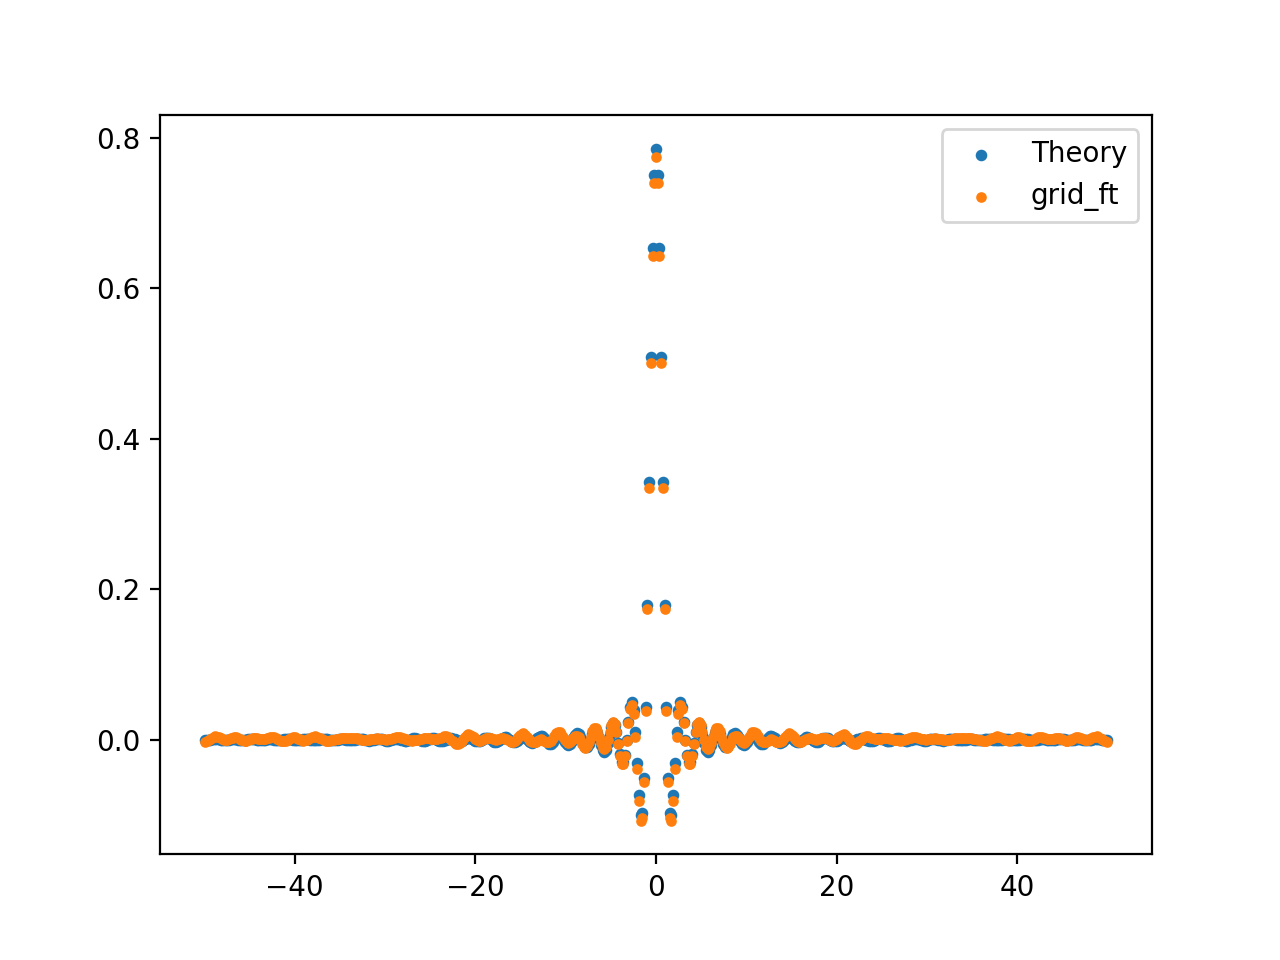

In [39]:
fig, ax = plt.subplots()
ax.scatter(f_grid_ft.axis_x.centers,
           scipy.fft.fftshift(Yc_theory, axes=0)[0, :], c='C0', s=10, label='Theory')
ax.scatter(f_grid_ft.axis_x.centers,
           np.real(scipy.fft.fftshift(Y_ft, axes=0))[0, :], c='C1', s=8, label='grid_ft')
ax.legend()

In [40]:
f_grid_ft_real, Y_ft_real = grid.ft(y, real=True) 

<IPython.core.display.Javascript object>


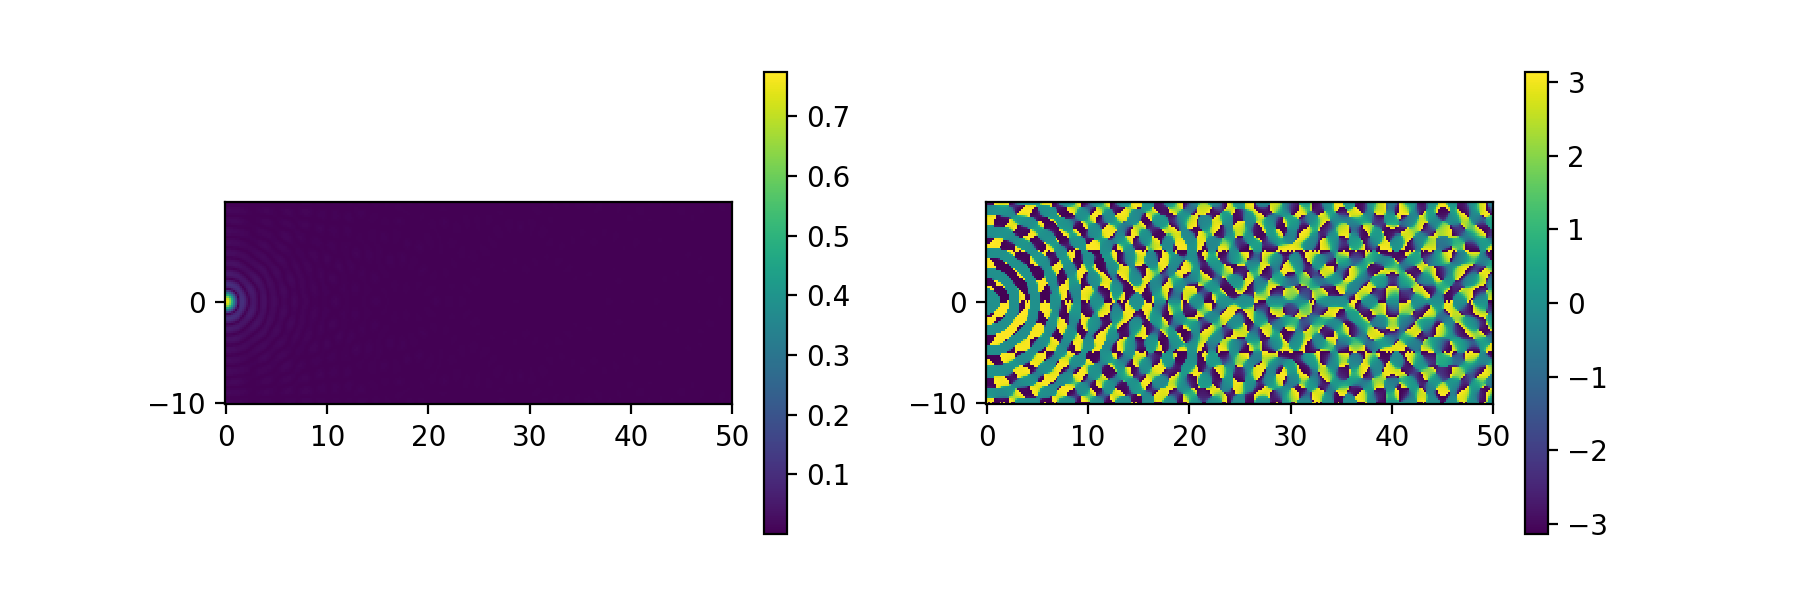

In [41]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
im = f_grid_ft_real.imshow(ax[0], np.abs(Y_ft_real))
fig.colorbar(im, ax=ax[0])
im = f_grid_ft_real.imshow(ax[1], np.angle(Y_ft_real), vmin=vmin, vmax=vmax)
fig.colorbar(im, ax=ax[1])

In [42]:
A = Y_ft[:, Y_ft.shape[1]//2:]
if Y_ft.shape[1] % 2 == 0:
    A = np.hstack((A, np.atleast_2d(Y_ft[:, 0]).T))

np.allclose(Y_ft_real, A)

True

In [43]:
np.allclose(scipy.fft.fftshift(scipy.fft.fft(y, n=scipy.fft.next_fast_len(N_y), axis=0), axes=0), grid.dft(y, axis=0)[1])

True

In [44]:
np.allclose(scipy.fft.fftshift(scipy.fft.fft(y, n=scipy.fft.next_fast_len(N_x), axis=1), axes=1), grid.dft(y, axis=1)[1])

True

In [45]:
np.allclose(scipy.fft.rfft(y, n=scipy.fft.next_fast_len(N_y), axis=0), grid.dft(y, axis=0, real=True)[1])

True

In [46]:
np.allclose(scipy.fft.fftshift(scipy.fft.fft(y, n=scipy.fft.next_fast_len(N_x), axis=1), axes=1), grid.dft(y, axis=1)[1])

True

In [47]:
np.allclose(scipy.fft.rfft(y, n=scipy.fft.next_fast_len(N_x), axis=1), grid.dft(y, axis=1, real=True)[1])

True

In [49]:
grid_axis0, Y_ft_axis0 = grid.ft(y, axis=0)

<IPython.core.display.Javascript object>


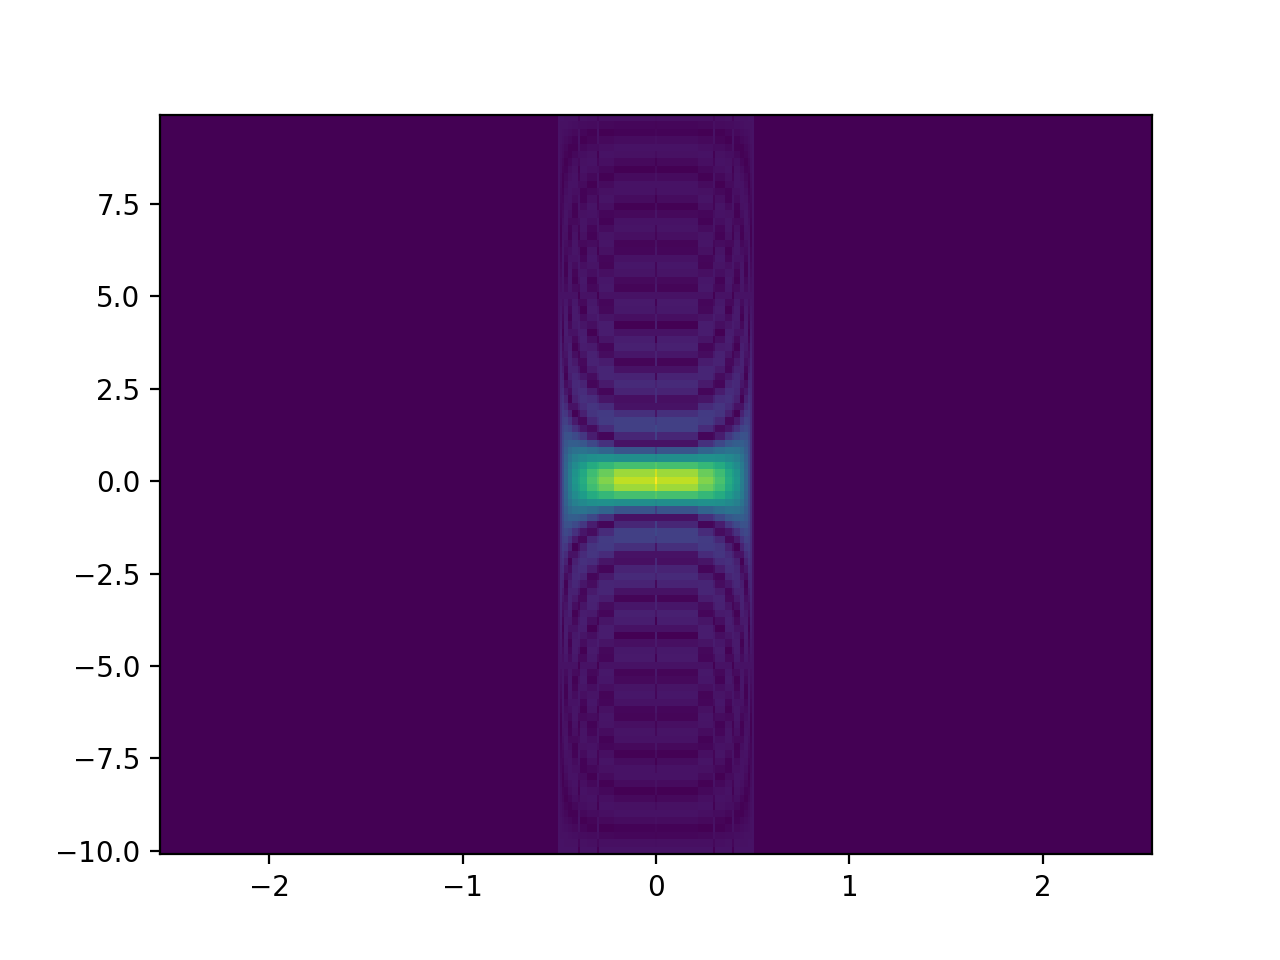

In [51]:
fig, ax = plt.subplots()
grid_axis0.imshow(ax, np.abs(Y_ft_axis0), aspect='auto')